# Experiment 1 Repeat Analysis started 2016-07-07

In preparation for manuscript.

In [1]:
import collections
from collections import defaultdict
import operator
import os
import re
import sys

from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

print 'pandas version', pd.__version__

%matplotlib inline

sys.path.append('../')
from common_code import data_util
from common_code import model_fitting

pandas version 0.19.2


## Constants

In [2]:
NUM_SAMPLES = 96

# NOTE: We later drop 6 samples suspecting cross-contamination,
# thus we end up analyzing 90 samples, as described in manuscript.

## Helper functions

Below, we'll find it useful to compare variants using a common primary key. For this purpose, we'll use tuples of the form (POSITION, REF). Let's make a helper function for generating the primary key.

In [3]:
def get_variant_key_for_df_row(df_row):
    """Parses unique key for a variant from Dataframe row.
    
    Returns key as tuple of the form: (POSITION, REF).
    """
    return (df_row['POSITION'], df_row['REF'])

## Data Import and Preparation

Import data. Similar to previous analyses.

In [4]:
MG1655_GENBANK = 'data/mg1655_U00096.2.gb'
mg1655_seq_record = SeqIO.read(MG1655_GENBANK, 'gb')
mg1655_seq_str = str(mg1655_seq_record.seq)

SNP data (exported from Millstone).

In [5]:
MELTED_VARIANT_DATA = (
        'data/fix_rec_variants_millstone_export_all_strains_2016_10_07.csv')
melted_variant_data_snps_only_df = pd.read_csv(
        MELTED_VARIANT_DATA, low_memory=False)

# Rename columns
melted_variant_data_snps_only_df.rename(
        columns={'EXPERIMENT_SAMPLE_LABEL': 'BARCODE'}, inplace=True)

# Get rid of rows that don't have sample in them (catch-all rows for VariantSets from Millstone).
melted_variant_data_snps_only_df = melted_variant_data_snps_only_df[
        melted_variant_data_snps_only_df['BARCODE'].notnull()]

# Drop samples named C321.*. These were included in the Millstone alignment
# but we are only focusing on Experiment 1 analysis here.
melted_variant_data_snps_only_df = melted_variant_data_snps_only_df[
        melted_variant_data_snps_only_df['BARCODE'].apply(
                lambda b: not bool(re.match('C321.*', b)))]

# Drop samples with LONG ref. We ignore SVs in this analysis.
def _is_sv(row):
    if pd.isnull(row['REF']):
        assert bool(re.match('LONG.*', row['ALT']))
        return True
    return bool(re.match('LONG.*', row['REF']))
melted_variant_data_snps_only_df = melted_variant_data_snps_only_df[
        melted_variant_data_snps_only_df.apply(lambda row: not _is_sv(row), axis=1)]

Import the designed UAG-to-UAA SNPs data and make sure all are accounted for.

In [6]:
# NOTE: These were manually updated.
amber_snps_df = pd.read_csv(
        'data/mg1655_uag_designs__freebayes_consolidated__2016_10_07.csv')
amber_snps_df.rename(columns={'POS': 'POSITION'}, inplace=True)

# Some UAGs are counted as a single SNP because they are adjacent.
SINGLE_SNP_COMBO_AMBERS = [
    633969, # 633970
    745946, # 745949 
]

# Some are not called but I visually confirmed they are there in Millstone.
UAG_NOT_CALLED_BUT_VISUALLY_VERIFIED = [
    1431010, # Poor mapping quality region
]    
amber_snps_df = amber_snps_df[
        amber_snps_df['POSITION'].apply(
                lambda p: p not in UAG_NOT_CALLED_BUT_VISUALLY_VERIFIED)]

NUM_AMBER_SNPS = 321 - len(SINGLE_SNP_COMBO_AMBERS) - len(UAG_NOT_CALLED_BUT_VISUALLY_VERIFIED)

assert NUM_AMBER_SNPS == len(amber_snps_df), len(amber_snps_df)

# Create (pos, ref) tuple set.
amber_pos_ref_tuple_set = set(amber_snps_df.apply(
        get_variant_key_for_df_row, axis=1))
assert NUM_AMBER_SNPS == len(amber_pos_ref_tuple_set)

Add Experiment data, e.g. wells, barcodes, lineage/timepoint identities, etc. These were calculated in Analysis 1.

In [7]:
METADATA = (
        'data/exp_1_sequencing_wells_barcodes_samples.csv')

experiment_metadata_df = pd.read_csv(METADATA)
experiment_metadata_df = experiment_metadata_df.rename(
        columns={'barcode': 'BARCODE'})
experiment_metadata_df['pos'] = (
        experiment_metadata_df['pos'].apply(
                data_util.normalize_well_name))

# Add sequencing layout data.
LAYOUT_TO_MAGE_CYCLE_MAPPING_DATA = (
        'data/exp_1_sequencing_layout_to_mage_cycle_mapping.csv')
layout_to_mage_cycle_mapping_df = pd.read_csv(LAYOUT_TO_MAGE_CYCLE_MAPPING_DATA)
layout_to_mage_cycle_mapping_df.rename(columns={'well': 'pos'}, inplace=True)
experiment_metadata_df = pd.merge(
        experiment_metadata_df,
        layout_to_mage_cycle_mapping_df[['pos', 'actual_mage_cycle']],
        how='inner',
        on='pos'
)

C321_I4_DT = experiment_metadata_df[
        experiment_metadata_df['pos'].apply(
                lambda p: p in ['H10', 'H11', 'H12'])]['doubling_time'].mean()
print 'C321_I4_DT', C321_I4_DT

# Wild-type doubling time was not measured on this plate, but approximated from other plates
# using relative ratios.
ECNR1_DT = 47
print 'ECNR1_DT', ECNR1_DT

experiment_metadata_df[-5:]

C321_I4_DT 87.0065433333
ECNR1_DT 47


,pos,rc_barcode,BARCODE,sample,doubling_time,lineage,time_point,actual_mage_cycle
91,H08,GACAGA,TCTGTC,03-06,70.113961,3,6,40
92,H09,GCGCTA,TAGCGC,05-06,60.102475,5,6,34
93,H10,GAAGTC,GACTTC,C321_I4,85.300355,0,0,0
94,H11,TTGATT,AATCAA,C321_I4,85.964804,0,0,0
95,H12,CGACTC,GAGTCG,C321_I4,89.754471,0,0,0


Merge with SNP data.

In [8]:
len_before_merge = len(melted_variant_data_snps_only_df)
melted_variant_data_unfiltered_df = pd.merge(
        melted_variant_data_snps_only_df,
        experiment_metadata_df,
        how='inner',
        on=['BARCODE'])
assert len_before_merge == len(melted_variant_data_unfiltered_df), (
        len_before_merge, len(melted_variant_data_unfiltered_df))

Below, we'll find it useful to compare variants using a common primary key. For this purpose, we'll use tuples of the form (POSITION, REF). Let's make a helper function for generating the primary key.

Filter out mutations that we know are not real (e.g. adjacent to lambda prophage scar) or inconsequential (mobile insertion elements) , or that we have determined are difficult to confirm via sequencing (e.g. homopolymer runs).

In [9]:
# First determine which keys to delete.
# Maintain map so we can quickly query by key, but also
# inspect by value.
to_delete_variant_keys_to_data_row_map = {}

MANUAL_IGNORE_SET = set([
    # lambda prophage locus
    (809582, 'A'),
    (806566, 'C'),
        
    # prfA deletion locus
    (1264224, 'C'),
    (1265309, 'C')
])

for _, row in melted_variant_data_unfiltered_df.iterrows():
    variant_key = get_variant_key_for_df_row(row)
    if variant_key in to_delete_variant_keys_to_data_row_map:
        continue
        
    if variant_key in amber_pos_ref_tuple_set:
        continue

    if pd.isnull(row['ALT']):
        continue

    # Ignore homopolymer runs.
    if len(row['ALT']) > 1:
        # Grab 2nd from end in case full homopolymer contained in ALT.
        # e.g. (3758149, AGGGGGGC)
        if len(row['ALT']) > 2:
            last_nt = row['ALT'][-2]
        else:
            last_nt = row['ALT'][-1]
        homopolymer_start = row['POSITION'] + 1
        if mg1655_seq_str[homopolymer_start:homopolymer_start + 5] == last_nt * 5:
            to_delete_variant_keys_to_data_row_map[variant_key] = row
            continue
            
    if len(row['REF']) > 2:
        last_nt = row['REF'][-2]
        homopolymer_start = row['POSITION'] + 1
        if mg1655_seq_str[homopolymer_start:homopolymer_start + 5] == last_nt * 5:
            to_delete_variant_keys_to_data_row_map[variant_key] = row
            continue
         
    # Manually ignore some mutation (e.g. lambda prophage).
    if variant_key in MANUAL_IGNORE_SET:
        to_delete_variant_keys_to_data_row_map[variant_key] = row
        continue
        
    # Ignore insertion elements.
    if not pd.isnull(row['INFO_EFF_GENE']) and row['INFO_EFF_GENE'][:3] == 'ins':
        to_delete_variant_keys_to_data_row_map[variant_key] = row
        continue
    
    
print 'Num variant keys to delete', len(to_delete_variant_keys_to_data_row_map)
       
# Sanity checks for SNPs that we should be ignoring.
TEST_DELETED_VARIANT_KEYS = [
    # false positive homopolymer run
    (3758149, 'AGGGGGGC'), 
    (4473579, 'CGGGGGGC'),
    (3509760, 'CAAAAAAAAC'),

    # insertion element
    (1426076, 'T'),
    
    # prfA
    (1264224, 'C'),
] + list(MANUAL_IGNORE_SET)

for test_deleted in TEST_DELETED_VARIANT_KEYS:
    assert test_deleted in to_delete_variant_keys_to_data_row_map, test_deleted

Num variant keys to delete 189


In [10]:
# Filter out the variants to delete identified above.
melted_variant_data_df = melted_variant_data_unfiltered_df[
        melted_variant_data_unfiltered_df.apply(
                lambda row: not get_variant_key_for_df_row(row) in
                        to_delete_variant_keys_to_data_row_map,
                axis=1)][:]

In [11]:
# Add an assert to make sure data doesn't change without us knowing.
NUM_SNPS_CALLED = 2250
assert NUM_SNPS_CALLED == len(set(melted_variant_data_df['POSITION'])), (
        len(set(melted_variant_data_df['POSITION'])))

NUM_SAMPLES = 96
assert NUM_SAMPLES == len(set(melted_variant_data_df['BARCODE']))

**NOTE**: We can still have more than one row per Variant if there are multiple alts.

Update GT_TYPEs based on AF as Freebayes was probably too conservative with this and to account for where we possibly had contamination.

In [12]:
# Save the original GT_TYPEs to another column.
melted_variant_data_df['original_GT_TYPE'] = melted_variant_data_df['GT_TYPE']

AF_ALT_THRESHOLD = 0.7

AF_REF_THRESHOLD = 0.1

def _update_gt_type(row):
    af = row['AF']
    if af >= AF_ALT_THRESHOLD:
        return 2
    elif af <= AF_REF_THRESHOLD:
        return 0
    else:
        return row['GT_TYPE']

melted_variant_data_df['GT_TYPE'] = melted_variant_data_df.apply(
        _update_gt_type, axis=1)

### Identify variants in the starting strain C321_I4 relative to MG1655

**NOTE**: Similar to Analysis 2.

We called variants relative to MG1655, so we need to determine variants in the starting strain as a reference point to identify reverted and new variants in descendant strains. Note that we ran freebayes in diploid mode, even though E. coli is haploid, so that we can more easily discern structural variations. Because of this, variants may be called as homozygous ref, heterozygous, or homozygous alt.

We'll leverage the fact that we sequenced 3 clones of the starting strains so that we can deal with data. We'll say that a variant is considered to be present in the starting strain if it was called at least heterozygous (GT_TYPE = 1 or GT_TYPE = 2) in all 3 clones, and called homozygous alt (GT_TYPE = 2) in at least one of the clones. We'll ignore the actual ALT value for now, digging deeper when necessary. We're okay with ignoring ALT for now because we are interested in observing the transition from some ALT back to REF.


Create structure containing all variants in starting set.

First a structure with all variants.

In [13]:
all_variant_pos_ref_tuple_set = set(melted_variant_data_df.apply(
        get_variant_key_for_df_row, axis=1))
print len(all_variant_pos_ref_tuple_set)
assert NUM_SNPS_CALLED == len(all_variant_pos_ref_tuple_set)

2250


In [14]:
# What are the duplicates.
pos_observed = {}
for (pos, ref) in all_variant_pos_ref_tuple_set:
    if pos in pos_observed:
        print pos, ref, pos_observed[pos]
    pos_observed[pos] = ref

Now we'll create structures that contain variants that occur in all 3 starting strains, as determined by these two criteria points mentioned above:

1. At least het (GT_TYPE = 1 or GT_TYPE = 2) in all 3 clones of C321_I4.
2. Called homozygous alt (GT_TYPE = 2) in at least 1 clone.

In [15]:
starting_strain_variants_df = melted_variant_data_df[
        melted_variant_data_df['sample'] == 'C321_I4']

# Variants that are at least HET in the starting strain.
variants_called_at_least_het_in_starting_strains_df = (
        starting_strain_variants_df[
                (starting_strain_variants_df.GT_TYPE == 2) |
                (starting_strain_variants_df.GT_TYPE == 1)])
print 'num at least het', len(variants_called_at_least_het_in_starting_strains_df.POSITION.unique())

# There's probably a pandas way to do this elegantly, but I'm going to
# do it iteratively for now.

# First, build a map from position to list of GT_TYPES.
position_to_gt_type_list_map = defaultdict(list)
for idx, row in variants_called_at_least_het_in_starting_strains_df.iterrows():
    position_to_gt_type_list_map[row['POSITION']].append(row['GT_TYPE'])
    
MANUALLY_VERIFIED_SNP_IN_STARTING_STRAIN = set([
    3726133, 3509760, 1757699, 4472155, 1632334])

# Now keep only those positions that satisfy (1) and (2) above,
# or are in the manual exception list.
positions_to_keep = []
for position, gt_type_list in position_to_gt_type_list_map.iteritems():
    if ((len(gt_type_list) >= 3 and 2 in gt_type_list) or
            position in MANUALLY_VERIFIED_SNP_IN_STARTING_STRAIN):
        positions_to_keep.append(position)
        
# Filter down the DataFrame to the positions satisfying our constraints.
starting_strain_variants_passing_filter = pd.merge(
        variants_called_at_least_het_in_starting_strains_df,
        pd.DataFrame({'POSITION': positions_to_keep}),
        how='inner',
        on='POSITION')

# Get the (POSITION, REF) tuple set.
variants_in_starting_strain_set = set(
        starting_strain_variants_passing_filter.apply(
                get_variant_key_for_df_row, axis=1))
print 'num variants in starting strain', len(variants_in_starting_strain_set)
assert 651 == len(variants_in_starting_strain_set) # break assert if unexpected code change

num at least het 675
num variants in starting strain 651


### Import Target Mutations Data

And check against called mutations from experiment.

#### UAG-to-UAA (Amber) Mutations

In [16]:
# Check that all UAGs are accounted for.
assert not amber_pos_ref_tuple_set - all_variant_pos_ref_tuple_set, (
        amber_pos_ref_tuple_set - all_variant_pos_ref_tuple_set)

# Check all UAGs accounted for in starting strains.
assert not amber_pos_ref_tuple_set - variants_in_starting_strain_set

#### Designed reversions

We import designed reversions. Note the commented code that follows where we create the designed set csv that adjusts for discrepancies between designs and how Freebayes calls them.

In [17]:
# NOTE: Freebayes called some variants differently than they were designed
# (e.g. REF/ALT of GCC/GC vs GC/G). We make a copy of the top designed SNPs
# and consolidate them manually in the csv file.
designed_set_df = pd.read_csv(
        'data/snp_data_top_ranked_final__freebayes_consolidated__2016_10_07.csv')

designed_set_df = designed_set_df.rename(
        columns={'POS': 'POSITION', 'ref': 'REF'})

# Create (pos, ref) tuple set.
designed_variant_pos_ref_tuple_set = set(designed_set_df.apply(
        get_variant_key_for_df_row, axis=1))
assert 127 == len(designed_variant_pos_ref_tuple_set)

# GK (2016-10-07): Visually confirmed that these are homopolymers and filtered out above.
MANUALLY_CONFIRMED_IGNORE_DESIGN_SET = set([
        (2212355, 'GCC'), (4036960, 'A'), (4472155, 'T'), (1683560, 'GC'),
        (1622373, 'AT'), (1867040, 'GT'), (3707578, 'G'), (2198468, 'GA'),
        (3726133, 'TCCCCCCCCG'), (3509760, 'CAAAAAAAAC')])

# Not observed in Experiment 1 at all.
missing_variant_set = (
        designed_variant_pos_ref_tuple_set -
        all_variant_pos_ref_tuple_set -
        MANUALLY_CONFIRMED_IGNORE_DESIGN_SET)
assert not missing_variant_set

print 'Designs considered for reversion: ', (
        len(designed_variant_pos_ref_tuple_set) -
        len(designed_variant_pos_ref_tuple_set - all_variant_pos_ref_tuple_set))

Designs considered for reversion:  117


The code below, now commented out, programatically fixed the Freebayes output to match our designs.

In [18]:
# updated_design_representation = []
# for _, row in designed_set_df.iterrows():
#     variant_key = get_variant_key_for_df_row(row)
#     if variant_key in all_variant_pos_ref_tuple_set:
#         updated_design_representation.append({
#             'POSITION': row['POSITION'],
#             'REF': row['REF'],
#             'ALT': row['alt']
#         })
#     else:
#         # Try to figure out the actual representation.
#         pos = variant_key[0]
        
#         # First try exact
#         matches_df = melted_variant_data_df[
#             (pos == melted_variant_data_df['POSITION']) &
#             (melted_variant_data_df['GT_TYPE'] == 2)][:]
#         if not len(matches_df):
#             matches_df = melted_variant_data_df[
#                 (pos - 10 <= melted_variant_data_df['POSITION']) &
#                 (melted_variant_data_df['POSITION'] <= pos + 10) &
#                 (melted_variant_data_df['GT_TYPE'] == 2)][:]
#         matches_df.drop_duplicates('POSITION', inplace=True)
#         if len(matches_df) == 1:
#             updated_design_representation.append({
#                 'POSITION': matches_df['POSITION'].values[0],
#                 'REF': matches_df['REF'].values[0],
#                 'ALT': matches_df['ALT'].values[0]
#             })
#         elif len(matches_df) > 1:
#             assert False, (pos, len(matches_df))
#         else:
#             updated_design_representation.append({
#                 'POSITION': row['POSITION'],
#                 'REF': row['REF'],
#                 'ALT': row['alt']
#             })
            
# updated_reversion_designs_df = pd.merge(
#     designed_set_df[['PRIORITY_SET', 'PRIORITY_INDIVIDUAL', 'POSITION', 'EFF_GENE']],
#     pd.DataFrame(updated_design_representation),
#     on='POSITION')

# updated_designs_pos_ref_tuple_set = set(updated_reversion_designs_df.apply(
#         get_variant_key_for_df_row, axis=1))
# assert 127 == len(updated_designs_pos_ref_tuple_set)

# # GK (2016-10-07): Visually confirmed that these are homopolymers and filtered out above.
# MANUALLY_CONFIRMED_IGNORE_DESIGN_SET = set([
#         (2212355, 'GCC'), (4036960, 'A'), (4472155, 'T'), (1683560, 'GC'),
#         (1622373, 'AT'), (1867040, 'GT'), (3707578, 'G'), (2198468, 'GA')])

# # Not observed in Experiment 1 at all.
# missing_variant_set = (
#         updated_designs_pos_ref_tuple_set -
#         all_variant_pos_ref_tuple_set -
#         MANUALLY_CONFIRMED_IGNORE_DESIGN_SET)
# print 'Not observed in Experiment 1 at all. Ignoring %d:' % len(missing_variant_set), missing_variant_set

# updated_reversion_designs_df.to_csv(
#     'data/snp_data_top_ranked_final__freebayes_consolidated__2016_10_07.csv',
#     index=False)

# designed_variant_pos_ref_tuple_set = updated_designs_pos_ref_tuple_set

**Add columns to the data that indicate how positions relate to the starting strain.**
 
0 = same allele as starting C321_I4  
1 = alt allele

In [19]:
MUTATION_TYPE__AMBER = 'AMBER'

MUTATION_TYPE__AMBER_REVERSION = 'AMBER_REVERSION'

MUTATION_TYPE__FIXED = 'FIXED'

MUTATION_TYPE__UNTARGETED_REVERSION = 'UNTARGETED_REVERSION'

MUTATION_TYPE__DE_NOVO = 'DE_NOVO'

MUTATION_TYPE__NONE = 'NONE'

def determine_mutation_type(row):
    """Determines the type of mutation. Possibilities:
        (FIXED, DE_NOVO, UNTARGETED_REVERSION, NONE)
        
    NOTE: This used to be represented in 2 different columns
    IS_FIXED and IS_DE_NOVO but we realized we additionally had
    mutations of type UNTARGETED_REVERSION. Rather than adding
    more boolean columns, use this enum column.
    """
    variant_key = get_variant_key_for_df_row(row)
    
    if variant_key in amber_pos_ref_tuple_set:
        if row['GT_TYPE'] == 2:
            return MUTATION_TYPE__AMBER
        else:
            return MUTATION_TYPE__AMBER_REVERSION
    if variant_key in designed_variant_pos_ref_tuple_set:
        if row['GT_TYPE'] == 0:
            return MUTATION_TYPE__FIXED
    elif variant_key in variants_in_starting_strain_set:
        if row['GT_TYPE'] == 0:
            return MUTATION_TYPE__UNTARGETED_REVERSION
    elif row['GT_TYPE'] == 2:
        # Neither in designed set or mutation in starting strain.
        return MUTATION_TYPE__DE_NOVO
    
    # Default. Meets no interesting condition.
    return MUTATION_TYPE__NONE

melted_variant_data_df['MUTATION_TYPE'] = melted_variant_data_df.apply(
        determine_mutation_type, axis=1)

# Add column indicating signal relative to starting strain, either 0 or 1.
# These are either reversions, or de novo mutations.
# Excludes ambers, or weak evidence mutations.
melted_variant_data_df['signal_relative_to_C321'] = (
        melted_variant_data_df['MUTATION_TYPE'].apply(
                lambda mt: mt in [
                        MUTATION_TYPE__FIXED,
                        MUTATION_TYPE__DE_NOVO,
                        MUTATION_TYPE__UNTARGETED_REVERSION
                ])).astype(int)

Visually inspect the ones that claim to be amber reversions.

In [20]:
melted_variant_data_df[
        melted_variant_data_df['MUTATION_TYPE'] ==
                MUTATION_TYPE__AMBER_REVERSION].drop_duplicates('POSITION')

,UID,POSITION,CHROMOSOME,REF,ALT,BARCODE,INFO_EFF,GT,IS_HET,GQ,...,pos,rc_barcode,sample,doubling_time,lineage,time_point,actual_mage_cycle,original_GT_TYPE,MUTATION_TYPE,signal_relative_to_C321
5806,a855d089,1632334,U00096.2,C,NaN,CCGTGA,[u'splice_region_variant+stop_retained_variant...,NaN,NaN,NaN,...,B12,TCACGG,05-07,60.662941,5,7,43,NaN,AMBER_REVERSION,0
166581,f69c77fe,1286207,U00096.2,G,A,CCAACC,[u'intergenic_region(MODIFIER|||n.1286207G>A||...,0/1,True,NaN,...,G02,GGTTGG,03-02,73.378095,3,2,19,1.0,AMBER_REVERSION,0


Visual inspection confirms these are really there, just weren't called correctly by Freebayes.

Correct these manually.

In [21]:
melted_variant_data_df['MUTATION_TYPE'] = (
        melted_variant_data_df['MUTATION_TYPE'].apply(
                lambda mt: mt if mt != MUTATION_TYPE__AMBER_REVERSION else MUTATION_TYPE__AMBER))

**Generate useful sets of (POSITION, REF) for fixed and de novo variants.**

In [22]:
amber_variants_set = set(melted_variant_data_df[
        melted_variant_data_df['MUTATION_TYPE'] == MUTATION_TYPE__AMBER].apply(
                get_variant_key_for_df_row, axis=1))
print len(amber_variants_set)
assert NUM_AMBER_SNPS == len(amber_variants_set) # catch data changes

amber_variants_df = melted_variant_data_df[
        melted_variant_data_df.apply(
                lambda row: get_variant_key_for_df_row(row) in
                        amber_variants_set, axis=1)]
print len(amber_variants_df)

318
30528


In [23]:
# Identify fixed variants going relative to starting strain.
variants_fixed_at_least_once = set(melted_variant_data_df[
        melted_variant_data_df['MUTATION_TYPE'] == 'FIXED'].apply(
                get_variant_key_for_df_row, axis=1))
print len(variants_fixed_at_least_once)
assert 99 == len(variants_fixed_at_least_once) # catch data changes

variants_fixed_at_least_once_df = melted_variant_data_df[
        melted_variant_data_df.apply(
                lambda row: get_variant_key_for_df_row(row) in
                        variants_fixed_at_least_once, axis=1)]
print len(variants_fixed_at_least_once_df)

99
9527


Inspect the ones never observed.

In [24]:
unobserved_design_versions_set = (
        designed_variant_pos_ref_tuple_set -
        MANUALLY_CONFIRMED_IGNORE_DESIGN_SET -
        variants_fixed_at_least_once)
designed_set_df[
        designed_set_df.apply(
                lambda row: get_variant_key_for_df_row(row) in unobserved_design_versions_set,
                axis=1)]

,PRIORITY_SET,PRIORITY_INDIVIDUAL,POSITION,EFF_GENE,ALT,REF
34,2,35,162927,hrpB,A,G
43,3,44,1286375,rttR,C,T
54,4,55,280883,yagA,CG,CGG
59,4,60,7922,yaaJ,CAAA,CAA
63,4,64,1207756,tfaE,TA,TCA
69,4,70,1005635,ycbW,TG,TGG
70,4,71,4509169,fecE,T,C
73,4,74,1755775,ynhG,CT,CTCTGGT
75,4,76,3506472,php,GC,GCC
85,4,86,3181028,zupT,A,G


In [25]:
untargeted_reversions_set = set(melted_variant_data_df[
        melted_variant_data_df['MUTATION_TYPE'] == 'UNTARGETED_REVERSION'].apply(
                get_variant_key_for_df_row, axis=1))
print len(untargeted_reversions_set)

untargeted_reversions_df = melted_variant_data_df[
        melted_variant_data_df.apply(
                lambda row: get_variant_key_for_df_row(row) in
                        untargeted_reversions_set, axis=1)]

6


Inspected these by eye and most appear to be tough to call (e.g. homopolymers or paralogous regions). Only 4617936 is a solid call, but it happens in a single clone at lineage 5 timepoint 7 so it is difficult to infer anything meaningful.

In [26]:
de_novo_variants = set(melted_variant_data_df[
        melted_variant_data_df['MUTATION_TYPE'] == 'DE_NOVO'].apply(
                get_variant_key_for_df_row, axis=1).values)
print len(de_novo_variants)

de_novo_variatns_df = melted_variant_data_df[
        melted_variant_data_df.apply(
                lambda row: get_variant_key_for_df_row(row) in
                        de_novo_variants, axis=1)]
print len(de_novo_variatns_df)

1336
128066


What about the remaining variants?  These are neither in starting set, fixed, nor de novo.

In [27]:
def is_variant_unaccounted_for(row):
    key = get_variant_key_for_df_row(row)
    return not (
            key in de_novo_variants or
            key in variants_in_starting_strain_set)
unaccounted_for_variants_df = melted_variant_data_df[
        melted_variant_data_df.apply(is_variant_unaccounted_for, axis=1)]

unaccounted_for_variants_position_set = set(unaccounted_for_variants_df['POSITION'])
print 'df size', len(unaccounted_for_variants_df)
print 'unique variant positions', len(unaccounted_for_variants_position_set)

print '# GT_TYPE=0', len(unaccounted_for_variants_df[unaccounted_for_variants_df['GT_TYPE'] == 0])
print '# GT_TYPE=1', len(unaccounted_for_variants_df[unaccounted_for_variants_df['GT_TYPE'] == 1])
print '# GT_TYPE=2', len(unaccounted_for_variants_df[unaccounted_for_variants_df['GT_TYPE'] == 2])
assert len(unaccounted_for_variants_df[unaccounted_for_variants_df['GT_TYPE'] == 2]) == 0

df size 25248
unique variant positions 263
# GT_TYPE=0 24105
# GT_TYPE=1 1143
# GT_TYPE=2 0


These are never GT_TYPE = 2 and mostly GT_TYPE = 0, so it appears that they are due to noise.

Thus it looks like that we've accounted for all variants.  The remaining ones were all het or homo ref. A few sanity checks and useful data structures

In [28]:
# Make sure all SNP positions are in some category.
assert NUM_SNPS_CALLED == (len(de_novo_variants) +
        len(variants_in_starting_strain_set) +
        len(unaccounted_for_variants_position_set))

SIGNAL_SNP_POSITIONS_SET = (
        set([x[0] for x in de_novo_variants]) |
        set([x[0] for x in variants_fixed_at_least_once]) |
        set([x[0] for x in untargeted_reversions_set])
)
assert len(SIGNAL_SNP_POSITIONS_SET) == (
        len(de_novo_variants) +
        len(variants_fixed_at_least_once) +
        len(untargeted_reversions_set))
NUM_SIGNAL_SNPS = len(SIGNAL_SNP_POSITIONS_SET)

# Sanity check: Another way of calculating that. Should match.
assert NUM_SIGNAL_SNPS == len(
        set(melted_variant_data_df[melted_variant_data_df['signal_relative_to_C321'] == 1]['POSITION']))

print 'de novo variants', len(de_novo_variants)
print 'variants in starting strain', len(variants_in_starting_strain_set)
print 'NUM_SIGNAL_SNPS', NUM_SIGNAL_SNPS

de novo variants 1336
variants in starting strain 651
NUM_SIGNAL_SNPS 1441


**Create a data structure that has annotation data only, useful for annotating model data.**

In [29]:
METADATA_FIELDS = [
    'POSITION',
    'REF',
    'ALT',
    'MUTATION_TYPE',
    'INFO_EFF_GENE',
    'INFO_EFF_IMPACT',
    'INFO_EFF_AA',
    'GT_TYPE'
]

variant_data_annotated_only_df = (
        melted_variant_data_df[
                (melted_variant_data_df['POSITION'].apply(
                        lambda p: p in SIGNAL_SNP_POSITIONS_SET)) &
                (melted_variant_data_df['GT_TYPE'].apply(lambda gt: gt in (1, 2)))])
variant_data_annotated_only_df = (
        variant_data_annotated_only_df.drop_duplicates(['POSITION', 'REF']))
variant_data_annotated_only_df = variant_data_annotated_only_df[METADATA_FIELDS]

# Add occurrence counts for these SNPS.
positive_signal_df = melted_variant_data_df[
    melted_variant_data_df['signal_relative_to_C321'] == 1]
counts_per_position_series = positive_signal_df['POSITION'].value_counts()
counts_per_position_df = counts_per_position_series.to_frame(name='count')
counts_per_position_df['POSITION'] = counts_per_position_df.index
variant_data_annotated_only_df = pd.merge(
    variant_data_annotated_only_df,
    counts_per_position_df,
    how='left',
    on='POSITION')

# Fix MUTTION_TYPE. The reason these may be broken is that
# variant_data_annotated_only_df was made by 
# dropping duplicates by position and ref, which might not
# have included a row of the appropriate GT_TYPE to have the
# right annotation.
def fix_mutation_type(row):
    variant_key = get_variant_key_for_df_row(row)
    if variant_key in variants_fixed_at_least_once:
        return MUTATION_TYPE__FIXED
    elif variant_key in untargeted_reversions_set:
        return MUTATION_TYPE__UNTARGETED_REVERSION
    elif variant_key in de_novo_variants:
        return MUTATION_TYPE__DE_NOVO
    else:
        return MUTATION_TYPE__NONE
    
variant_data_annotated_only_df['MUTATION_TYPE'] = (
        variant_data_annotated_only_df.apply(
                fix_mutation_type, axis=1))

# Assert all accounted for.
assert not len(variant_data_annotated_only_df[
        variant_data_annotated_only_df['MUTATION_TYPE'] == MUTATION_TYPE__NONE])

assert len(variant_data_annotated_only_df) == len(
        set(variant_data_annotated_only_df['POSITION']))
# assert len(variant_data_annotated_only_df) == NUM_SIGNAL_SNPS

In [30]:
print 'FIXED', len(
        variant_data_annotated_only_df[
                variant_data_annotated_only_df['MUTATION_TYPE'] ==
                        MUTATION_TYPE__FIXED])

print 'DE NOVO', len(
        variant_data_annotated_only_df[
                variant_data_annotated_only_df['MUTATION_TYPE'] ==
                        MUTATION_TYPE__DE_NOVO])

FIXED 99
DE NOVO 1336


## Analyze Mutation Dynamics

Look at dynamics of how mutations arise in the population.

First, for each sample, count the number of de novo and reversion mutations.

In [31]:
per_clone_mutation_counts_df = experiment_metadata_df[[
        'pos', 'BARCODE', 'sample', 'doubling_time', 'lineage', 'time_point', 'actual_mage_cycle']][:]

def get_mutation_counts(barcode):
    return melted_variant_data_df[
        melted_variant_data_df['BARCODE'] == barcode]['MUTATION_TYPE'].value_counts()
per_clone_mutation_counts_df = per_clone_mutation_counts_df.join(
        per_clone_mutation_counts_df['BARCODE'].apply(get_mutation_counts))

# Add HET counts.
def get_orig_het_counts(barcode):
    return len(melted_variant_data_df[
        (melted_variant_data_df['BARCODE'] == barcode) &
        (melted_variant_data_df['original_GT_TYPE'] == 1)])
per_clone_mutation_counts_df['ORIG_HET_COUNT'] = (
        per_clone_mutation_counts_df['BARCODE'].apply(
                get_orig_het_counts))

def get_updated_het_counts(barcode):
    return len(melted_variant_data_df[
        (melted_variant_data_df['BARCODE'] == barcode) &
        (melted_variant_data_df['GT_TYPE'] == 1)])
per_clone_mutation_counts_df['UPDATED_HET_COUNT'] = (
        per_clone_mutation_counts_df['BARCODE'].apply(
                get_updated_het_counts))

# Add a column showing average rate of FIXED mutations.
per_clone_mutation_counts_df['FIXED_per_MAGE_cycle'] = (
        per_clone_mutation_counts_df[MUTATION_TYPE__FIXED] / per_clone_mutation_counts_df['actual_mage_cycle'])

# Add a column showing average rate of de novo mutations.
per_clone_mutation_counts_df['DE_NOVO_per_MAGE_cycle'] = (
        per_clone_mutation_counts_df[MUTATION_TYPE__DE_NOVO] / per_clone_mutation_counts_df['actual_mage_cycle'])

# Add a column showing ratio of de novo vs fixed.
per_clone_mutation_counts_df['DE_NOVO_to_FIXED_ratio'] = (
        per_clone_mutation_counts_df['DE_NOVO'] / per_clone_mutation_counts_df['FIXED'])

# Inspect one of these.
per_clone_mutation_counts_df[per_clone_mutation_counts_df['sample'] == '01-01']

,pos,BARCODE,sample,doubling_time,lineage,time_point,actual_mage_cycle,AMBER,DE_NOVO,FIXED,NONE,UNTARGETED_REVERSION,ORIG_HET_COUNT,UPDATED_HET_COUNT,FIXED_per_MAGE_cycle,DE_NOVO_per_MAGE_cycle,DE_NOVO_to_FIXED_ratio
0,A01,AACCTG,01-01,78.331670,1,1,5,318.0,NaN,NaN,1930.0,NaN,43,30,NaN,NaN,NaN
12,B01,CACCGT,01-01,77.343979,1,1,5,318.0,6.0,1.0,1923.0,NaN,21,11,0.2,1.2,6.0
24,C01,AGTAAT,01-01,76.202194,1,1,5,318.0,2.0,NaN,1928.0,NaN,31,17,NaN,0.4,NaN
36,D01,GCGCTA,01-01,71.441390,1,1,5,318.0,3.0,1.0,1926.0,NaN,34,25,0.2,0.6,3.0


Drop samples with excessive HET counts. We found these HET counts to be significantly different than the rest of the wells. These likely suffered cross-contamination. This is why we describe 90 samples, not 96.

In [32]:
high_het_barcodes_set = set(
        per_clone_mutation_counts_df[
                per_clone_mutation_counts_df['UPDATED_HET_COUNT'] > 30]['BARCODE'])
print 'NUM HIGH HET BARCODES', len(high_het_barcodes_set)

per_clone_mutation_counts_df = per_clone_mutation_counts_df[
        per_clone_mutation_counts_df['BARCODE'].apply(
                lambda b: b not in high_het_barcodes_set)]

melted_variant_data_df = melted_variant_data_df[
        melted_variant_data_df['BARCODE'].apply(
                lambda b: b not in high_het_barcodes_set)]

NUM HIGH HET BARCODES 6


Aggregate by sample.

In [33]:
aggregate_per_sample_mutation_counts_df = per_clone_mutation_counts_df.groupby('sample').agg({
    'sample': {
        'count': 'count'
    },
    'lineage': 'first',
    'time_point': 'first',
    'actual_mage_cycle': 'first',
    'doubling_time': {
        'mean': 'mean',
        'stdev': 'std'
    },
    'FIXED': {
        'mean': 'mean',
        'stdev': 'std'
    },
    'DE_NOVO': {
        'mean': 'mean',
        'stdev': 'std'
    },
    'UNTARGETED_REVERSION': {
        'mean': 'mean',
        'stdev': 'std'
    },
    'AMBER': {
        'mean': 'mean',
        'stdev': 'std'
    },
})[['sample', 'lineage', 'time_point', 'actual_mage_cycle', 'doubling_time',
        'FIXED', 'DE_NOVO', 'UNTARGETED_REVERSION', 'AMBER']]

aggregate_per_sample_mutation_counts_df

sample lineage time_point actual_mage_cycle doubling_time             \
         count   first      first             first         stdev       mean   
sample                                                                         
01-01        4       1          1                 5      3.052262  75.829808   
01-02        3       1          2                14      2.871387  71.789395   
01-03        3       1          3                18      3.999653  73.915334   
01-04        4       1          4                20      4.001593  70.207219   
01-05        4       1          5                25      2.802409  65.267806   
01-06        4       1          6                31      3.068573  64.561708   
01-07        4       1          7                40      2.454961  62.669426   
03-01        4       3          1                 5      0.503411  82.107917   
03-02        4       3          2                19      2.479869  70.254887   
03-03        4       3          3                26      6.640756  66.323141   
03-04        4       3          4                28      6.990662  67.893865   
03-05        4       3          5                34      4.505766  62.819313   
03-06        4       3          6                40      2.586030  66.807928   
03-07        7       3          7                49      2.666364  58.299511   
05-01        4       5          1                11      4.179874  79.542669   
05-02        4       5          2                16      1.968539  72.614709   
05-03        4       5          3                21      4.830638  71.136283   
05-04        4       5          4                23      5.051717  73.612972   
05-05        3       5          5                28      1.892164  59.461666   
05-06        4       5          6                34      3.805866  62.951005   
05-07        7       5          7                43      1.877327  61.308703   
C321_I4      3       0          0                 0      2.402853  87.006543   

            FIXED               DE_NOVO            UNTARGETED_REVERSION       \
            stdev       mean      stdev       mean                stdev mean   
sample                                                                         
01-01    0.000000   1.000000   2.081666   3.666667                  NaN  NaN   
01-02    0.577350   2.333333   2.516611   9.333333                  NaN  1.0   
01-03    3.055050   4.333333   1.154701  13.666667                  NaN  NaN   
01-04    3.403430   5.250000   2.500000  19.750000                  NaN  1.0   
01-05    1.732051   7.500000   3.403430  26.250000                  NaN  1.0   
01-06    0.957427   9.250000   3.095696  28.250000             0.000000  1.0   
01-07    2.160247  10.000000   5.123475  35.750000                  NaN  1.0   
03-01    0.000000   2.000000   2.753785   4.750000                  NaN  NaN   
03-02    2.943920   6.000000   5.560276  17.750000                  NaN  NaN   
03-03    4.573474   8.750000   1.707825  21.250000             0.000000  1.0   
03-04    4.924429   7.750000   1.414214  21.000000             0.000000  1.0   
03-05    4.509250   7.500000  12.311918  29.250000             0.577350  1.5   
03-06    2.943920   8.000000   8.883505  34.250000             0.000000  1.0   
03-07    2.225395   8.428571   7.967195  35.142857             0.894427  1.6   
05-01    1.892969   3.250000   2.645751   9.500000             0.000000  1.0   
05-02    1.825742  10.000000   4.434712  18.500000             0.707107  1.5   
05-03    1.707825   7.250000   2.828427  19.000000                  NaN  1.0   
05-04    1.258306   7.250000   4.898979  20.000000                  NaN  1.0   
05-05    2.000000   8.000000   1.732051  31.000000             0.000000  1.0   
05-06    4.856267  11.750000   1.632993  33.000000             0.000000  1.0   
05-07    4.041452  12.000000   8.202787  37.571429             1.732051  2.0   
C321_I4       NaN        NaN   0.577350   2.333333                  NaN  NaN   

      

Plot mutations vs time for each lineage.

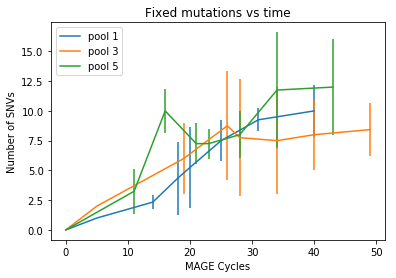

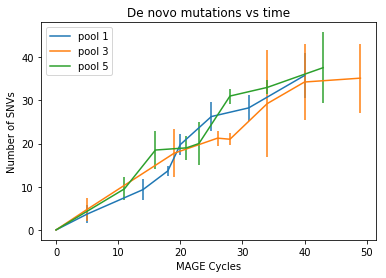

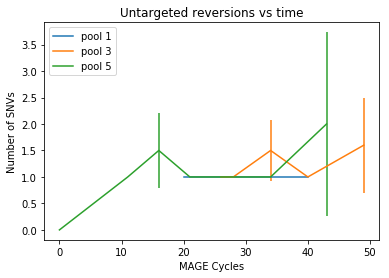

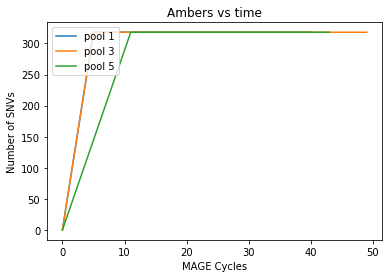

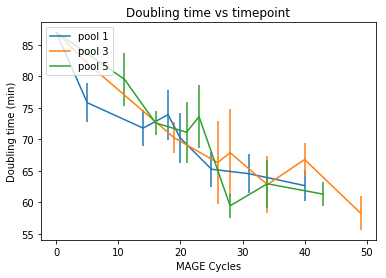

In [34]:
LINEAGES = [1, 3, 5]

TIME_POINTS = sorted(list(set(experiment_metadata_df['time_point'])))

LINE_STYLES = ['bo-', 'go-', 'ro-']

LINEAGE_NAMES = ['pool 1', 'pool 3', 'pool 5']


def get_mutation_count_timeseries(lineage, mutation_type):
    mage_cycle_list = []
    mean_list = []
    std_list = []
    for time_point in TIME_POINTS:
        if time_point == 0:
            if mutation_type == 'doubling_time':
                mage_cycle_list.append(0)
                mean_list.append(C321_I4_DT)
                std_list.append(0)
            else:
                mage_cycle_list.append(0)
                mean_list.append(0)
                std_list.append(0)
            continue
        time_point_match = aggregate_per_sample_mutation_counts_df[
            (aggregate_per_sample_mutation_counts_df['time_point']['first'] == time_point) &
            (aggregate_per_sample_mutation_counts_df['lineage']['first'] == lineage)
        ]
        mage_cycle_list.append(time_point_match['actual_mage_cycle'].values[0])
        mean_list.append(time_point_match[mutation_type]['mean'].values[0])
        std_list.append(time_point_match[mutation_type]['stdev'].values[0])
    return mage_cycle_list, mean_list, std_list


def plot_lineage(lineage, mutation_type, line_style):
    """Plot a single lineage.
    """
    mage_cycle_list, mean_list, std_list = get_mutation_count_timeseries(
            lineage, mutation_type)
    return plt.errorbar(
            mage_cycle_list, mean_list, yerr=std_list)
    

def plot_lineage_comparison(
        title, mutation_type, ylabel='Number of SNVs'):
    """Plots the 3 lineages together.
    """
    plt.figure()

    lineage_plots = []
    for lineage, line_style in zip(LINEAGES, LINE_STYLES):
        lineage_plots.append(plot_lineage(lineage, mutation_type, line_style)[0])
    
    plt.title(title)
    plt.xlabel('MAGE Cycles')
    plt.ylabel(ylabel)
    plt.legend(lineage_plots, LINEAGE_NAMES, numpoints=1, loc=2)
    
plot_lineage_comparison('Fixed mutations vs time', MUTATION_TYPE__FIXED)
plot_lineage_comparison('De novo mutations vs time', MUTATION_TYPE__DE_NOVO)
plot_lineage_comparison('Untargeted reversions vs time', MUTATION_TYPE__UNTARGETED_REVERSION)
plot_lineage_comparison('Ambers vs time', MUTATION_TYPE__AMBER)
plot_lineage_comparison('Doubling time vs timepoint', 'doubling_time', ylabel='Doubling time (min)')

Plot individual counts, not averages.

In [35]:
# We will still separate by lineage to give us
# the option of coloring the points differently.

def get_lineage_timeseries(lineage=None):
    mage_cycle_ordered_list = []
    doubling_time_ordered_list = []
    lineage_data_df = per_clone_mutation_counts_df[
            per_clone_mutation_counts_df['lineage'] == lineage]
    return {
        'mage_cycle_ordered_list': np.array(lineage_data_df['actual_mage_cycle']),
        'doubling_time_ordered_list': np.array(lineage_data_df['doubling_time']),
        'fixed_mutation_ordered_list': np.array(lineage_data_df[MUTATION_TYPE__FIXED]),
        'de_novo_mutation_ordered_list': np.array(lineage_data_df[MUTATION_TYPE__DE_NOVO]),
        'de_novo_to_fixed_ratio': np.array(lineage_data_df['DE_NOVO_to_FIXED_ratio'])
    }

lineage_0_data = get_lineage_timeseries(0)
lineage_1_data = get_lineage_timeseries(1)    
lineage_3_data = get_lineage_timeseries(3) 
lineage_5_data = get_lineage_timeseries(5) 

Plot doubling times.

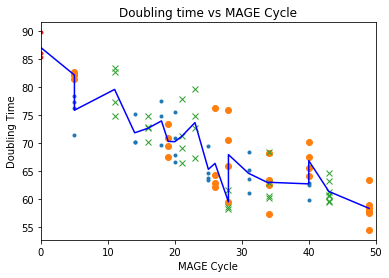

In [36]:
plt.figure()

plt.plot(
        lineage_1_data['mage_cycle_ordered_list'],
        lineage_1_data['doubling_time_ordered_list'],
        '.')

plt.plot(
        lineage_3_data['mage_cycle_ordered_list'],
        lineage_3_data['doubling_time_ordered_list'],
        'o')

plt.plot(
        lineage_5_data['mage_cycle_ordered_list'],
        lineage_5_data['doubling_time_ordered_list'],
        'x')
plt.plot(
        lineage_0_data['mage_cycle_ordered_list'],
        lineage_0_data['doubling_time_ordered_list'],
        '.')

# Plot mean.
# Grab all mage cycles and means.
# Lack of pandas skillz makes me do it the brute force way for now.
data_obj_list = []
for idx, row in aggregate_per_sample_mutation_counts_df.iterrows():
    x = row
    data_obj_list.append({
        'lineage': x['lineage']['first'],
        'actual_mage_cycle': x['actual_mage_cycle']['first'],
        'doubling_time_mean': row['doubling_time']['mean'],
        'doubling_time_stdev': row['doubling_time']['stdev']
    })
mean_doubling_times_df = pd.DataFrame(data_obj_list)
mean_doubling_times_df.sort_values('actual_mage_cycle', inplace=True)

# Plot mean.
plt.plot(
        mean_doubling_times_df['actual_mage_cycle'],
        mean_doubling_times_df['doubling_time_mean'], 'b')

# # Plot stdev above and below.
# stdev_above = (
#         mean_doubling_times_df['doubling_time_mean'] +
#         mean_doubling_times_df['doubling_time_stdev'])
# plt.plot(
#         mean_doubling_times_df['actual_mage_cycle'],
#         stdev_above)
# stdev_below = (
#         mean_doubling_times_df['doubling_time_mean'] -
#         mean_doubling_times_df['doubling_time_stdev'])
# plt.plot(
#         mean_doubling_times_df['actual_mage_cycle'],
#         stdev_below)

# plt.axhline(y=C321_FIX_DT)

plt.title('Doubling time vs MAGE Cycle')
plt.xlabel('MAGE Cycle')
plt.ylabel('Doubling Time')
plt.xlim([0, 50])
plt.show()

Similarly, plot individual mutation counts rather than averages.

In [37]:
def plot_mutation_list(lineage_data, mutation_key, style):
    plt.plot(
            lineage_data['mage_cycle_ordered_list'],
            lineage_data[mutation_key],
            style)

Fixed mutations.

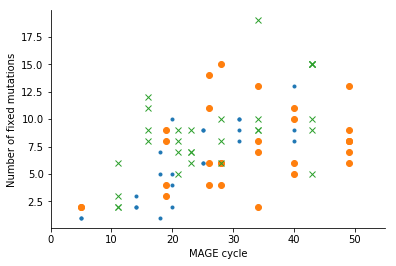

In [38]:
plt.figure()
plot_mutation_list(lineage_1_data, 'fixed_mutation_ordered_list', '.')
plot_mutation_list(lineage_3_data, 'fixed_mutation_ordered_list', 'o')
plot_mutation_list(lineage_5_data, 'fixed_mutation_ordered_list', 'x')
# plot_mutation_list(lineage_0_data, 'fixed_mutation_ordered_list', '.')
# plt.title('Fixed mutations vs MAGE Cycle')
plt.xlabel('MAGE cycle')
plt.ylabel('Number of fixed mutations')

ax = plt.axes()
ax.set_xlim([0, 55])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.show()

De novo mutations.

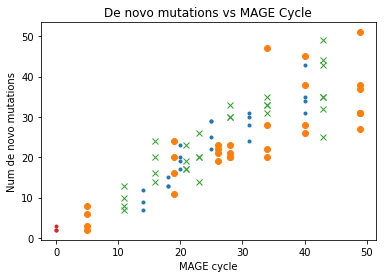

In [39]:
plt.figure()
plot_mutation_list(lineage_1_data, 'de_novo_mutation_ordered_list', '.')
plot_mutation_list(lineage_3_data, 'de_novo_mutation_ordered_list', 'o')
plot_mutation_list(lineage_5_data, 'de_novo_mutation_ordered_list', 'x')
plot_mutation_list(lineage_0_data, 'de_novo_mutation_ordered_list', '.')

plt.title('De novo mutations vs MAGE Cycle')
plt.xlabel('MAGE cycle')
plt.ylabel('Num de novo mutations')
plt.show()

Curiously we see some clones with relatively few de novo mutations and others with many.

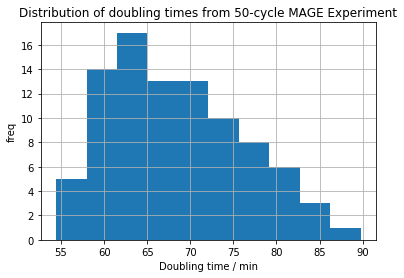

In [40]:
plt.figure()
per_clone_mutation_counts_df['doubling_time'].hist()
plt.title('Distribution of doubling times from 50-cycle MAGE Experiment')
plt.xlabel('Doubling time / min')
plt.ylabel('freq')
plt.show()

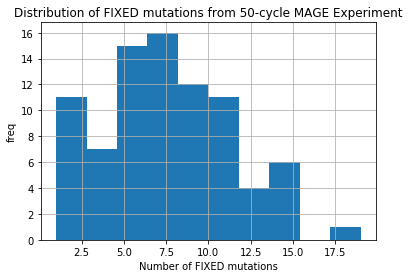

In [41]:
plt.figure()
per_clone_mutation_counts_df[MUTATION_TYPE__FIXED].hist()
plt.title('Distribution of FIXED mutations from 50-cycle MAGE Experiment')
plt.xlabel('Number of FIXED mutations')
plt.ylabel('freq')
plt.show()

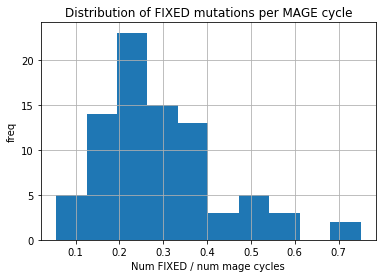

In [42]:
plt.figure()
per_clone_mutation_counts_df[
        per_clone_mutation_counts_df['actual_mage_cycle'] > 0][
                'FIXED_per_MAGE_cycle'].hist()
plt.title('Distribution of FIXED mutations per MAGE cycle')
plt.xlabel('Num FIXED / num mage cycles')
plt.ylabel('freq')
plt.show()

What are doubling times of clones with most FIXED mutations?

In [43]:
per_clone_mutation_counts_df.sort_values(MUTATION_TYPE__FIXED, ascending=False)[:5]

,pos,BARCODE,sample,doubling_time,lineage,time_point,actual_mage_cycle,AMBER,DE_NOVO,FIXED,NONE,UNTARGETED_REVERSION,ORIG_HET_COUNT,UPDATED_HET_COUNT,FIXED_per_MAGE_cycle,DE_NOVO_per_MAGE_cycle,DE_NOVO_to_FIXED_ratio
80,G09,TGAACA,05-06,68.370715,5,6,34,318.0,33.0,19.0,1878.0,NaN,20,14,0.558824,0.970588,1.736842
83,G12,AGGATA,05-07,63.150454,5,7,43,318.0,25.0,15.0,1891.0,NaN,22,12,0.348837,0.581395,1.666667
76,G05,TACTCA,03-04,65.921636,3,4,28,318.0,21.0,15.0,1893.0,1.0,12,10,0.535714,0.750000,1.400000
23,B12,CCGTGA,05-07,60.662941,5,7,43,318.0,44.0,15.0,1867.0,4.0,23,14,0.348837,1.023256,2.933333
47,D12,GAATGC,05-07,64.540241,5,7,43,318.0,43.0,15.0,1871.0,1.0,23,11,0.348837,1.000000,2.866667


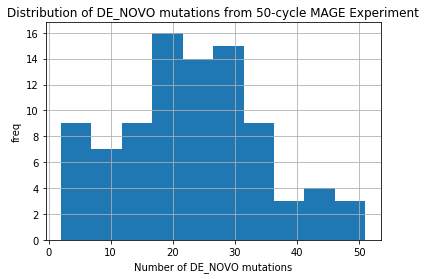

In [44]:
plt.figure()
per_clone_mutation_counts_df[MUTATION_TYPE__DE_NOVO].hist()
plt.title('Distribution of DE_NOVO mutations from 50-cycle MAGE Experiment')
plt.xlabel('Number of DE_NOVO mutations')
plt.ylabel('freq')
plt.show()

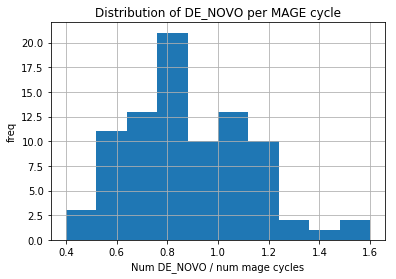

In [45]:
plt.figure()
per_clone_mutation_counts_df[
        per_clone_mutation_counts_df['actual_mage_cycle'] > 0][
                'DE_NOVO_per_MAGE_cycle'].hist()
plt.title('Distribution of DE_NOVO per MAGE cycle')
plt.xlabel('Num DE_NOVO / num mage cycles')
plt.ylabel('freq')
plt.show()

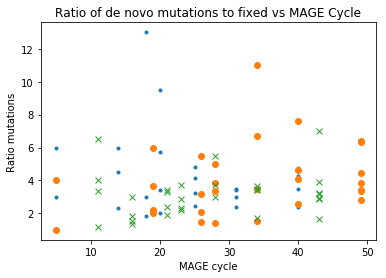

In [46]:
plt.figure()
plot_mutation_list(lineage_1_data, 'de_novo_to_fixed_ratio', '.')
plot_mutation_list(lineage_3_data, 'de_novo_to_fixed_ratio', 'o')
plot_mutation_list(lineage_5_data, 'de_novo_to_fixed_ratio', 'x')
plot_mutation_list(lineage_0_data, 'de_novo_to_fixed_ratio', '.')

plt.title('Ratio of de novo mutations to fixed vs MAGE Cycle')
plt.xlabel('MAGE cycle')
plt.ylabel('Ratio mutations')
plt.show()

In [47]:
print 'ECNR1_DT (min)', ECNR1_DT
print 'C321_I4_DT (min)', C321_I4_DT

original_defect = float(C321_I4_DT - ECNR1_DT) / ECNR1_DT

def get_mean_timepoint_improvement(t):
    return aggregate_per_sample_mutation_counts_df['doubling_time']['mean'][
            aggregate_per_sample_mutation_counts_df['time_point']['first'] == t].mean()

print 'mean final clone improvement', (C321_I4_DT - get_mean_timepoint_improvement(7)) / float(C321_I4_DT - ECNR1_DT)
final_clone_doubling_times = (
        experiment_metadata_df[
                experiment_metadata_df['time_point'] == 7]['doubling_time'])

print 'original_defect', original_defect
print 'Min improvement fraction', (C321_I4_DT - max(final_clone_doubling_times)) / float(C321_I4_DT - ECNR1_DT)
print 'Max improvement fraction', (C321_I4_DT - min(final_clone_doubling_times)) / float(C321_I4_DT - ECNR1_DT)

ECNR1_DT (min) 47
C321_I4_DT (min) 87.0065433333
mean final clone improvement 0.656075928103
original_defect 0.851203049645
Min improvement fraction 0.532223845383
Max improvement fraction 0.813944135638


The doubling time graph appears to asymptote around 20 cycles of MAGE. Count how many of the clones have doubling time below some threshold by 20 cycles of MAGE.

Count how many FIXED mutations observed in each pool.

In [48]:
print 'All pools', len(set(melted_variant_data_df[
        melted_variant_data_df['MUTATION_TYPE'] == MUTATION_TYPE__FIXED]['POSITION']))

print 'Pool 1', len(set(melted_variant_data_df[
        (melted_variant_data_df['lineage'] == 1) &
        (melted_variant_data_df['MUTATION_TYPE'] == MUTATION_TYPE__FIXED)]['POSITION']))

print 'Pool 3', len(set(melted_variant_data_df[
        (melted_variant_data_df['lineage'] == 3) &
        (melted_variant_data_df['MUTATION_TYPE'] == MUTATION_TYPE__FIXED)]['POSITION']))

print 'Pool 5', len(set(melted_variant_data_df[
        (melted_variant_data_df['lineage'] == 5) &
        (melted_variant_data_df['MUTATION_TYPE'] == MUTATION_TYPE__FIXED)]['POSITION']))

All pools 99
Pool 1 24
Pool 3 58
Pool 5 86


Count DE NOVO mutations.

In [49]:
print 'All pools', len(set(melted_variant_data_df[
        melted_variant_data_df['MUTATION_TYPE'] == MUTATION_TYPE__DE_NOVO]['POSITION']))


All pools 1329


Export data for making figures in R.

In [50]:
melted_variant_data_df[[
    'POSITION',
    'REF',
    'ALT',
    'BARCODE',
    'GT_TYPE',
    'sample',
    'doubling_time',
    'lineage',
    'time_point',
    'actual_mage_cycle',
    'MUTATION_TYPE',
    'signal_relative_to_C321'
]].to_csv('outputs/exp_1_data_export_minimal_columns.csv', index=False)

## Model Fitting

First we define the procedure.

In [51]:
def add_annotation_metadata(model_df):
    """Adds annotations.
    """
    model_with_metadata_df = pd.merge(
            model_df,
            variant_data_annotated_only_df,
            how='inner', # why are some not found?
            on=['POSITION']
    )
    assert len(model_df) == len(model_with_metadata_df)
    return model_with_metadata_df


def run_linear_modeling(
        filtered_variant_data_df,
        doubling_time_source_df,
        repeats=10,
        test_size=20,
        l1_ratio_list=[.1, .3, .5, .7, .9, .95, .99, 1],
        min_coef_abs_threshold=None,
        max_rank_threshold=None,
        prune_and_repeat_cycles=1,
        doubling_time_key='log_doubling_time'):
    """Function that runs our linear model technique.
    """
    # At most one of these for now. Could theoretically support both.
    assert min_coef_abs_threshold is None or max_rank_threshold is None

    # Return all runs of linear modeling for quantification purposes.
    lm_results_list = []
    
    sample_to_snp_occurrence_matrix_gt_type = (
            model_fitting.generate_sample_to_signal_pivot_table(
                    filtered_variant_data_df))

    # Verify that they are sorted by barcode.
    index_list = list(sample_to_snp_occurrence_matrix_gt_type.index)
    assert index_list == sorted(index_list)
    
    # Get doubling times, only for included barcodes.
    doubling_times = model_fitting.get_doubling_times_array(
            doubling_time_source_df,
            barcode_filter=sample_to_snp_occurrence_matrix_gt_type.index,
            doubling_time_key=doubling_time_key)

    # We apply cross-validated ElasticNet in order to fit the parameters alpha and
    # l1_ratio, while also identifying the most impactful SNPs. We repeat
    # multiple times to get different fits depending on cross/train split.
    current_elastic_cv_result = model_fitting.multiple_apply_elastic_net_cv(
            sample_to_snp_occurrence_matrix_gt_type,
            doubling_times,
            add_annotation_metadata,
            repeats=repeats,
            test_size=test_size,
            l1_ratio_list=l1_ratio_list)
    lm_results_list.append(current_elastic_cv_result)
    
    # Repeat using only the coefficients that pass some threshold defined by args.
    
    # Determine what to use as tresholding.
    if min_coef_abs_threshold is not None:
        thresholding = 'COEF'
    elif max_rank_threshold is not None:
        thresholding = 'RANK'
    else:
        thresholding = 'COEF'
        min_coef_abs_threshold = 0
    assert thresholding in ['COEF', 'RANK']

    for it in range(prune_and_repeat_cycles):
        
        # Prune SNPs that don't meet threshold.
        keep_snp_features = []
        if thresholding == 'COEF':
            # Calculate mean model coefficient for each observed SNP.
            snp_to_average_coef_dict = {}
            
            # Weighted by score.
            normalized_score_list = (
                    np.array(current_elastic_cv_result['score_list']) /
                    sum(current_elastic_cv_result['score_list']))
            
            for snp, coef_list in current_elastic_cv_result['snp_to_coef_list_dict'].iteritems():
                snp_to_average_coef_dict[snp] = sum(np.array(coef_list) * normalized_score_list)

            # Figure out which ones to keep based on threshold.
            for snp, coef in snp_to_average_coef_dict.iteritems():
                if coef <= 0 and abs(coef) > min_coef_abs_threshold:
                    keep_snp_features.append(snp)
        elif thresholding == 'RANK':
            # Calculate mean ranking for each observed SNP.
            snp_to_average_rank_dict = {}
            for snp, rank_list in current_elastic_cv_result['snp_to_ranking_list_dict'].iteritems():
                not_None_rank_list = [x for x in rank_list if x is not None]
                snp_to_average_rank_dict[snp] = np.mean(not_None_rank_list)

            # Figure out which ones to keep based on threshold.
            for snp, rank in snp_to_average_rank_dict.iteritems():
                if abs(rank) <= max_rank_threshold:
                    keep_snp_features.append(snp)
        else:
            raise AssertionError('Invalid thresholding: %s' % thresholding)

        sample_to_snp_occurrence_matrix_top_snps_only_df = (
                sample_to_snp_occurrence_matrix_gt_type[keep_snp_features])
        current_elastic_cv_result = model_fitting.multiple_apply_elastic_net_cv(
                sample_to_snp_occurrence_matrix_top_snps_only_df,
                doubling_times,
                add_annotation_metadata,
                repeats=repeats,
                test_size=test_size,
                l1_ratio_list=l1_ratio_list)
        lm_results_list.append(current_elastic_cv_result)
        
    top_snps_repeated_elastic_cv_result = current_elastic_cv_result

    # Calculate mean model coefficient for each observed SNP.
    snp_to_average_coef_dict = {}

    # Weighted by score.
    normalized_score_list = (
            np.array(top_snps_repeated_elastic_cv_result['score_list']) /
            sum(top_snps_repeated_elastic_cv_result['score_list']))
    for snp, coef_list in top_snps_repeated_elastic_cv_result['snp_to_coef_list_dict'].iteritems():
        snp_to_average_coef_dict[snp] = sum(np.array(coef_list) * normalized_score_list)
        
    sorted_avg_coef_list = sorted(
            snp_to_average_coef_dict.items(), key=operator.itemgetter(1))
    print 'Num SNPs with > 0 average coefficient:', len(sorted_avg_coef_list)
    
    # Prepare report.
    data_obj_list = []
    for pos, coef in sorted_avg_coef_list:
        data_obj_list.append({
            'POSITION': pos,
            'model_coef': coef
        })

    report_df = pd.merge(
        pd.DataFrame(data_obj_list),
        variant_data_annotated_only_df,
        on='POSITION')
    
    return report_df, lm_results_list

Now in prep for running modeling, we filter variants to those that are fixed and any de novo that occur at least 2 times.

In [52]:
melted_variant_data_df['log_doubling_time'] = np.log(melted_variant_data_df['doubling_time'])

reverted_position_set = set(variant_data_annotated_only_df[
        (variant_data_annotated_only_df['MUTATION_TYPE'] == MUTATION_TYPE__FIXED)
]['POSITION'])

de_novo_position_set = set(variant_data_annotated_only_df[
        ((variant_data_annotated_only_df['MUTATION_TYPE'] == MUTATION_TYPE__DE_NOVO) &
        (variant_data_annotated_only_df['count'] >= 2))
]['POSITION'])

keep_position_set = reverted_position_set | de_novo_position_set

f_variant_data_df = melted_variant_data_df[
        (melted_variant_data_df['POSITION'].apply(
                lambda p: p in keep_position_set))
]

total_num_snps_considered = len(f_variant_data_df['POSITION'].unique())
print 'Num SNP features considered:', total_num_snps_considered
print '...Reverted: ', len(reverted_position_set)
print '...De Novo: ', len(de_novo_position_set)
print 'Num samples considered:', len(f_variant_data_df['BARCODE'].unique())

Num SNP features considered: 234
...Reverted:  99
...De Novo:  135
Num samples considered: 90


Now run modeling.

NOTE: Modeling result / model_coef values hard-coded to match Fig. 3. The modeling result is stochastic depending on train-test split with respect to alleles with weaker effect. See **Methods**.

In [53]:
LM_RESULT__ALL_DF, LM_RESULT__ALL__RESULTS_LIST = run_linear_modeling(
        f_variant_data_df,
        melted_variant_data_df,
        repeats=100,
        prune_and_repeat_cycles=1,
        test_size=15,
        doubling_time_key='log_doubling_time')

LM_RESULT__ALL_DF

Num SNPs with > 0 average coefficient: 8


,POSITION,model_coef,REF,ALT,MUTATION_TYPE,INFO_EFF_GENE,INFO_EFF_IMPACT,INFO_EFF_AA,GT_TYPE,count
0,4102449,-0.119654,A,G,FIXED,cpxA,MODERATE,p.Trp184Arg/c.550T>C,2.0,60
1,3990077,-0.046998,C,T,DE_NOVO,cyaA,MODERATE,p.Pro301Leu/c.902C>T,2.0,31
2,1263523,-0.044777,T,C,FIXED,hemA,MODERATE,p.Leu196Pro/c.587T>C,2.0,78
3,3092256,-0.035126,T,C,DE_NOVO,yggR,MODERATE,p.Thr283Ala/c.847A>G,2.0,46
4,1511492,-0.030327,T,C,DE_NOVO,ydcT,MODERATE,p.Ser218Pro/c.652T>C,2.0,17
5,200214,-0.011817,C,T,FIXED,bamA,MODERATE,p.Pro763Ser/c.2287C>T,2.0,10
6,672170,-0.006232,C,A,FIXED,leuS,MODERATE,p.Val613Phe/c.1837G>T,2.0,18
7,322579,-0.001609,C,T,DE_NOVO,ykgF,MODERATE,p.Pro340Ser/c.1018C>T,2.0,69
